This notebook compares the VICE outputs to the single zone analytic equations

In [1]:
%load_ext autoreload
%autoreload 2
# %config Completer.use_jedi = False

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from dataclasses import dataclass


/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
from scipy.special import expi

In [4]:
import vice
import surp
from surp import gce_math as gcem

In [5]:
surp.yields.set_magg22_scale()
surp.set_yields()

yields set to Magg et al. 2022 abundances
yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0.00e+00                       
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





# Analytic definitions

In [6]:
@dataclass
class sz_params:
    η: float = 0.5
    r: float = 0.4
    τ_star: float = 2
    τ_sfh: float = 15
        
    t_d_agb: float = 0# 0.1
    τ_agb: float = 0.1
        
    y_c_agb: float = 0.000566
    y_c_cc: float = 0.00205
    ζ_c_agb: float = 0# vice.yields.ccsne.settings["c"].zeta
    ζ_c_cc: float = 0#vice.yields.agb.settings["c"].zeta
        
    y_o: float = vice.yields.ccsne.settings["o"]
    y_fe_cc: float = vice.yields.ccsne.settings["fe"]
    y_fe_ia: float = vice.yields.sneia.settings["fe"]
        
    τ_ia: float = 1.5
    κ_ia: float = -1.1
    t_d_ia: float = 0.15
        
    t_end: float = 13.2

    sfh: str = "const"
    
        
    @property 
    def ϖ(self):
        return 1 / self.τ_dep
    
    @property
    def τ_dep(self):
        return self.τ_star / (1 + self.η - self.r)# - self.τ_star / self.τ_sfh)

In [7]:
def ϵ(t):
    return np.exp(-t)

def ξ(t):
    return t*np.exp(-t)

def Γ(κ, t):
    return -gammainc(κ, t)

def harmon_diff(a, b):
    return 1/(1/a - 1/b)

In [8]:
def Zeq_cc_const(t, y, params=sz_params()):
    return y / (1 + params.η - params.r)

def Zeq_agb_const(t, params=sz_params()):
    return Zeq_cc_const(0, params.y_c_agb, params)

def Zeq_ia_const(t, params=sz_params()):
    return Zeq_cc_const(0, params.y_fe_ia, params)

In [9]:
def z_cc_const(t, y, params = sz_params()):
    ϖ = params.ϖ
    s = 1 - ϵ(ϖ * t)
    return y / params.τ_star * s / ϖ


def z_fe_ia_const(t, params = sz_params()):
    ϖ = params.ϖ
    ι = 1 / params.τ_ia
    
    δt = t - params.t_d_ia
    
    s = 1 
    s += - ϖ/(ϖ - ι) * ϵ(ι * δt)
    s += + ι/(ϖ - ι) * ϵ(ϖ * δt)
    s = np.where(δt <= 0, 0, s)
    
    Zeq = params.y_fe_ia / params.τ_star  / ϖ
    return Zeq * s

def z_c_agb_const(t, params=sz_params()):
    α = 1/params.τ_agb
    ϖ = params.ϖ
    δt = t - params.t_d_agb
    
    s = 1 / ϖ 
    s += 1/(α - ϖ) * ξ(α * δt)
    s += (2*α- ϖ) / (α - ϖ)**2 * ϵ(α * δt)
    s += -(1/ϖ + (2*α- ϖ) / (α - ϖ)**2) * ϵ(ϖ * δt)
    
    s = np.where(δt < 0, 0, s)

    return params.y_c_agb * s / params.τ_star

In [45]:
def Zeq_cc_exp(y, params=sz_params()):
    return y / (1 + params.η - params.r - params.τ_star / params.τ_sfh)

def nu_fe_exp(t, params=sz_params()):
    # from WAF
    τ_ia = params.τ_ia
    τ_sfh = params.τ_sfh
    t_D = params.t_d_ia
    
    return harmon_diff(τ_ia, τ_sfh)/τ_ia * np.exp(t_D/τ_sfh) * ( 1  -  np.exp(-(t - t_D)/harmon_diff(τ_ia, τ_sfh)) )
    
def Zeq_ia_exp(params=sz_params()):
    ϖ = params.ϖ
    ϕ = 1 / params.τ_sfh
    ι = 1 / params.τ_ia
    t_d = params.t_d_ia
    
    return params.y_fe_ia / (params.τ_star * (ϖ - ϕ)) * ι / (ι - ϕ) * ϵ(-ϕ * t_d)

In [183]:
harmon_diff(1.5, 5)

2.1428571428571432

In [50]:
params = sz_params()

In [51]:
Zeq_ia_exp(params)

np.float64(0.0008939524467296656)

In [52]:
nu_fe_exp(10000, params) * params.y_fe_ia / (params.τ_star * (params.ϖ - 1/params.τ_sfh))

np.float64(0.0008939524467296659)

In [58]:
def z_cc_exp(t, y, params = sz_params()):
    ϖ = params.ϖ 
    ϕ = 1 / params.τ_sfh
    s = 1 - ϵ((ϖ-ϕ) * t)
    return Zeq_cc_exp(y, params) * s 


def z_fe_ia_exp(t, params = sz_params()):
    ϖ = params.ϖ
    ι = 1 / params.τ_ia
    ϕ = 1 / params.τ_sfh
    δ = 1 / params.τ_dep
    
    Δt = t - params.t_d_ia
    
    s = (
        1 - ϵ((δ - ϕ) * Δt)
        - (δ - ϕ) / (δ - ι) * ( ϵ((ι - ϕ) * Δt) - ϵ(Δt * (δ - ϕ)) )
    )
    
    s = np.where(Δt <= 0, 0, s)
    
    Zeq = Zeq_ia_exp(params)
    return Zeq * s


def z_c_agb_exp(t, params=sz_params()):
    return 0

## extra

In [13]:

def R_int_ia(t, params=sz_params()):
    κ = params.κ_ia
    t_d = params.t_d_ia    
    R0 = (κ + 1) / (params.t_end**(κ + 1) - t_d**(κ + 1))

    r = t**(κ+1) - t_d**(κ+1)
    return r * R0 / (κ + 1)

# A SneFe model allowing for changes to the DTD exponent
def fe_ia_model_plaw(t, params=sz_params()):
    ϖ = params.ϖ
    κ = params.κ_ia
    t_d = params.t_d_ia
    
    t = np.array(t)
    
    Zeq = params.y_fe_ia / params.τ_star * 1 / ϖ
    R0 = (κ + 1) / (0 - t_d**(κ + 1))
    
    Γ0 = Γ(κ+2, -ϖ*t_d)
    coef = (-ϖ)**(-κ - 1)
    c = np.array([
        float(
            (coef * (Γ(κ+2, -ϖ*x) - Γ0)
            ).real) for x in t])
    
    i = np.array([
        float(
            (coef * (Γ(κ+2, -ϖ*x) - Γ0)
            ).imag) for x in t])
    
    s =  -ϵ(ϖ*t) * c
    s += -t_d**(κ + 1) * (1 - ϵ(ϖ*t - ϖ*t_d))
    
    s = np.where(t >= t_d, s, 0)

    return s * Zeq  * R0 / (κ + 1)




## Combined models

In [14]:
def c_model(t, params):
    if params.sfh == "const":
        return z_c_agb_const(t, params) + z_cc_const(t, params.y_c_cc, params)
    elif params.sfh == "exp":
        return z_cc_exp(t, params.y_c_cc, params)
    else:
        raise ValueError("sfh not recognized")


def fe_model(t, params):
    if params.sfh == "const":
        return z_fe_ia_const(t, params) + z_cc_const(t, params.y_fe_cc, params)
    elif params.sfh == "exp":
        return z_fe_ia_exp(t, params) + z_cc_exp(t, params.y_fe_cc, params)
    else:
        raise ValueError("sfh not recognized")

def o_model(t, params):
    if params.sfh == "const":
        return z_cc_const(t, params.y_o, params)
    elif params.sfh == "exp":
        return z_cc_exp(t, params.y_o, params)
    else:
        raise ValueError("sfh not recognized")

In [15]:
def run_analytic(t=np.linspace(0, 13.2, 10000), params=sz_params()):
    df = pd.DataFrame()
    df["time"] = t
    df["z(c)"] = c_model(t, params)
    df["z(o)"] = o_model(t, params)
    df["z(fe)"] = fe_model(t, params)

    add_abund_columns(df)

    return df

# Singlezone run

In [81]:
def sfh_const():
    return lambda t: 1 + 0*t

def sfh_exp(tau):
    return lambda t: np.exp(-t/tau)

def get_sfh(params):
    if params.sfh == "const":
        return sfh_const()
    elif params.sfh == "exp":
        return sfh_exp(params.τ_sfh)
    else:
        raise ValueError("sfh not known")


def set_yields(params = sz_params(), model="A"):
    if model == "A":
        surp.yields.set_yields(
            y_c_cc="Lin",
            zeta_c_cc=params.ζ_c_cc, 
            y0_c_cc=params.y_c_cc,
            Y_c_agb="A", 
            y_fe_ia=params.y_fe_ia,
            y_fe_cc=params.y_fe_cc,
            y_o_cc= params.y_o,

            kwargs_c_agb=dict(
                tau_agb = params.τ_agb,
                t_D = params.t_d_agb,
                zeta = 0,
            
        ))
        
    
def sz_model( params=sz_params(), dt=0.01, t_end=13.2, mode="sfr", RIa="exp", **kwargs):
    set_yields(params, **kwargs)

    sfh = get_sfh(params)
    sz = vice.singlezone(elements=["o", "mg", "c", "fe"], func=sfh, mode=mode, dt=dt, 
                         eta=params.η,  tau_star=params.τ_star, Mg0=1)
    
    sz.RIa = RIa
    out = sz.run(np.arange(0, t_end, dt), capture=True, overwrite=True)
    h = out.history
    
    add_abund_columns(h)

    return h


def add_abund_columns(sz):
    zo = np.array(sz["z(o)"])
    zfe = np.array(sz["z(fe)"])
    zc = np.array(sz["z(c)"])
    t = np.array(sz["time"])
    
    
    o_h = gcem.abund_to_brak(zo, "o")
    c_o = gcem.abund_ratio_to_brak(zc/zo, "c", "o")
    o_fe = gcem.abund_ratio_to_brak(zo/zfe, "o", "fe")

    sz["O_H"] = o_h
    sz["C_O"] = c_o
    sz["O_Fe"] = o_fe

# Plots

In [59]:
def compare_z_t(sz, ana):

    for ele in ["fe", "o", "c"]:
        plt.plot(sz['time'], sz[f"z({ele})"], label="VICE")
        
        plt.plot(ana.time, ana[f"z({ele})"], label="analytic")
        
        plt.xscale('log')
        plt.xlabel("time")
        plt.ylabel(f"$Z_{{\\rm {ele.title()}}}$")

        if ele == "o":
            Zeq = Zeq_cc_exp(params.y_o, params)
            plt.axhline(Zeq)
            
        plt.legend()
        plt.show()
    

In [23]:
def compare_abund(sz, ana):
    plt.plot(sz["O_H"], sz["O_Fe"], label="vice")
    plt.plot(ana["O_H"], ana["O_Fe"], label="analytic")
    
    plt.xlabel("[Mg/H]")
    plt.ylabel("[Mg/Fe]")
    
    plt.legend()
    plt.show()

    plt.plot(sz["O_H"], sz["C_O"], label="vice")
    plt.plot(ana["O_H"], ana["C_O"], label="analytic")
    
    plt.xlabel("[Mg/H]")
    plt.ylabel("[C/Mg]")
    
    plt.legend()
    plt.show()
    
    plt.plot(sz["O_Fe"], sz["C_O"], label="vice")
    plt.plot(ana["O_Fe"], ana["C_O"], label="analytic")
    
    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")
    
    plt.legend()
    plt.show()


    

## Constant

In [118]:
params = sz_params(y_fe_cc=0)
params

sz_params(η=0.5, r=0.4, τ_star=2, τ_sfh=15, t_d_agb=0, τ_agb=0.1, y_c_agb=0.000566, y_c_cc=0.00205, ζ_c_agb=0, ζ_c_cc=0, y_o=0.00713, y_fe_cc=0, y_fe_ia=0.00077, τ_ia=1.5, κ_ia=-1.1, t_d_ia=0.15, t_end=13.2, sfh='const')

In [119]:
sz = sz_model(params)

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.05e-03 + 0.00e+00 (Z - Z0)   (5.80e-04 + 0.00e+00(Z-Zo)),   0.00e+00                       
                                                   t_D=0.00, tau=0.10                                            

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   0.00e+00                       0                              7.70e-04                       





/tmp/ipykernel_2004284/3364224104.py:59: RuntimeWarning: invalid value encountered in divide
  c_o = gcem.abund_ratio_to_brak(zc/zo, "c", "o")
/tmp/ipykernel_2004284/3364224104.py:60: RuntimeWarning: divide by zero encountered in divide
  o_fe = gcem.abund_ratio_to_brak(zo/zfe, "o", "fe")
/tmp/ipykernel_2004284/3364224104.py:60: RuntimeWarning: invalid value encountered in divide
  o_fe = gcem.abund_ratio_to_brak(zo/zfe, "o", "fe")


In [120]:
vice.yields.ccsne.settings["c"].y0

0.00205

In [121]:
params.y_c_agb = surp.yields.calc_y( kind="agb")
ana = run_analytic(params=params)

/arc7/home/dboyea/surp/surp/gce_math.py:81: RuntimeWarning: divide by zero encountered in log10
  return np.log10(data) - np.log10(solar_z(ele))
/tmp/ipykernel_2004284/3364224104.py:59: RuntimeWarning: invalid value encountered in divide
  c_o = gcem.abund_ratio_to_brak(zc/zo, "c", "o")
/tmp/ipykernel_2004284/3364224104.py:60: RuntimeWarning: divide by zero encountered in divide
  o_fe = gcem.abund_ratio_to_brak(zo/zfe, "o", "fe")
/tmp/ipykernel_2004284/3364224104.py:60: RuntimeWarning: invalid value encountered in divide
  o_fe = gcem.abund_ratio_to_brak(zo/zfe, "o", "fe")


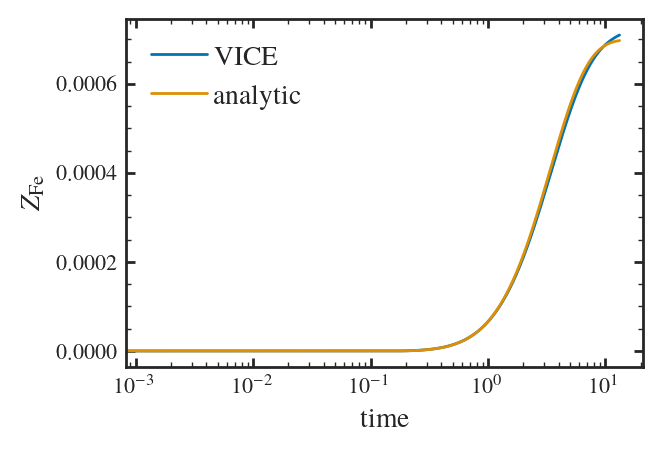

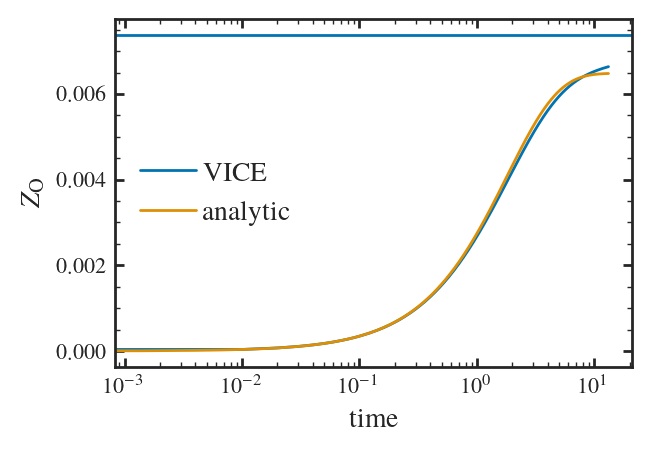

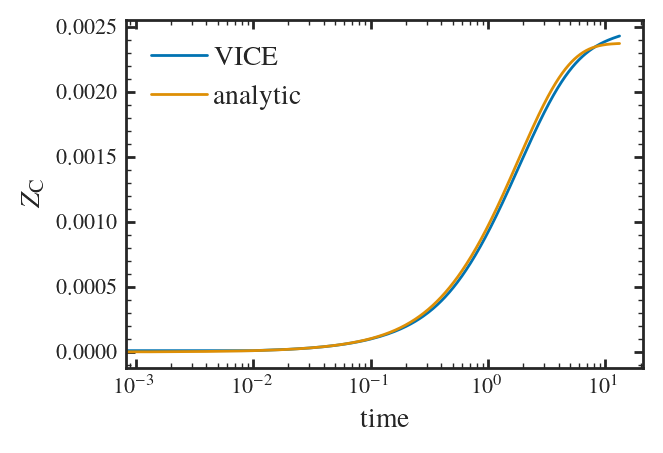

In [122]:
compare_z_t(sz, ana)

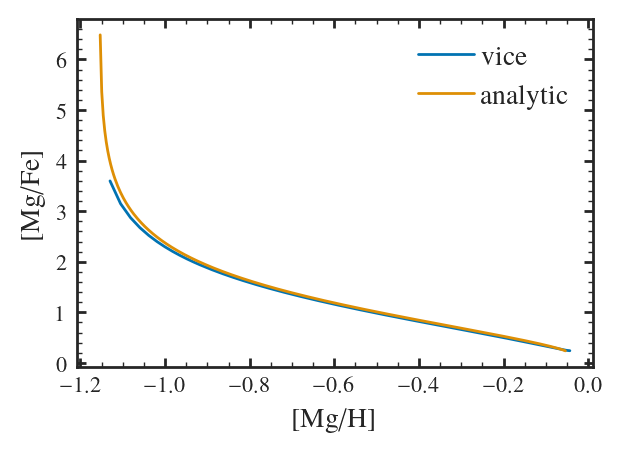

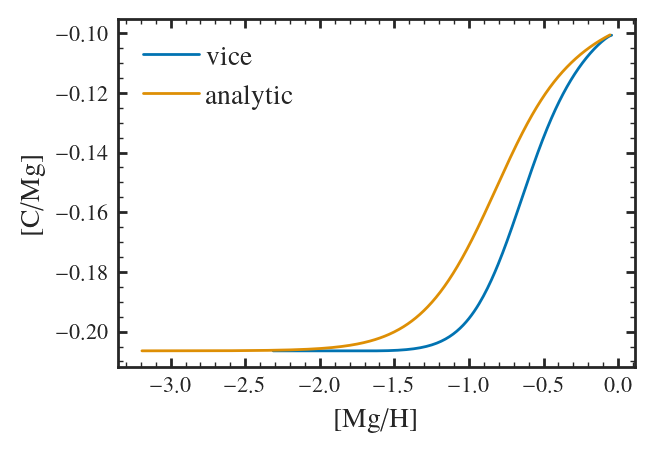

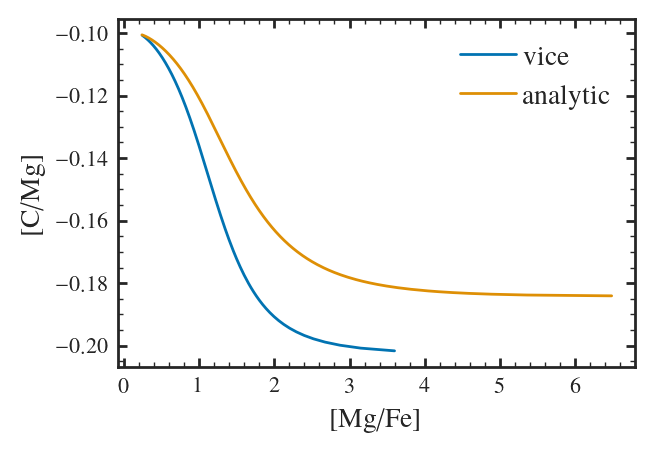

In [123]:
compare_abund(sz, ana)

## Exponential

In [151]:
params = sz_params(sfh="exp", τ_sfh=5, y_fe_cc=0)

In [152]:
params

sz_params(η=0.5, r=0.4, τ_star=2, τ_sfh=5, t_d_agb=0, τ_agb=0.1, y_c_agb=0.000566, y_c_cc=0.00205, ζ_c_agb=0, ζ_c_cc=0, y_o=0.00713, y_fe_cc=0, y_fe_ia=0.00077, τ_ia=1.5, κ_ia=-1.1, t_d_ia=0.15, t_end=13.2, sfh='exp')

In [153]:
ana = run_analytic(np.linspace(0.001, 10, 1000), params=params)

/tmp/ipykernel_2004284/3364224104.py:60: RuntimeWarning: divide by zero encountered in divide
  o_fe = gcem.abund_ratio_to_brak(zo/zfe, "o", "fe")


In [154]:
sz = sz_model(params, t_end=10)

/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,


yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.05e-03 + 0.00e+00 (Z - Z0)   (5.80e-04 + 0.00e+00(Z-Zo)),   0.00e+00                       
                                                   t_D=0.00, tau=0.10                                            

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   0.00e+00                       0                              7.70e-04                       





/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: o
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: mg
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute wi

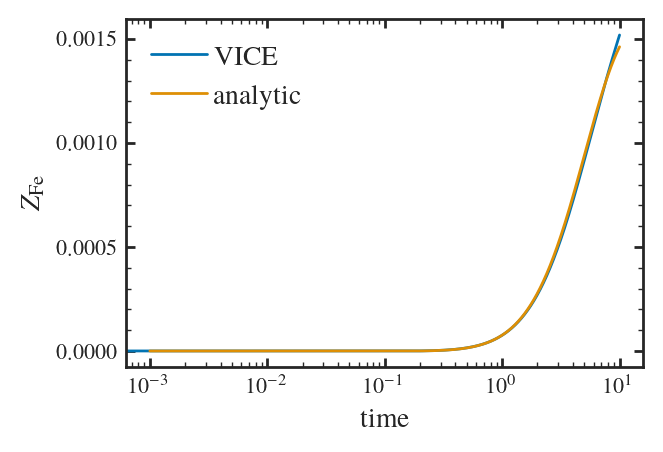

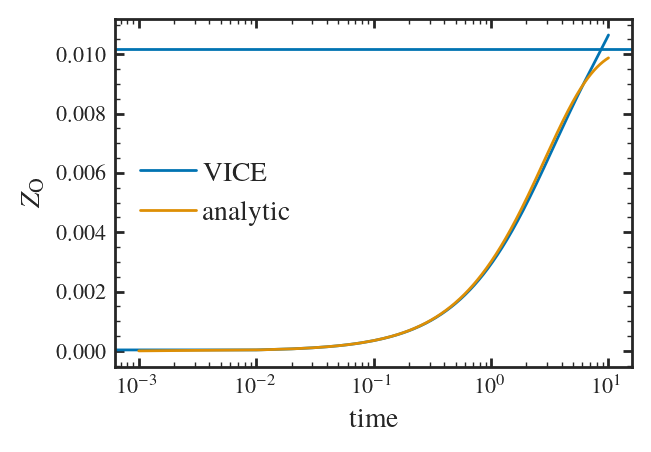

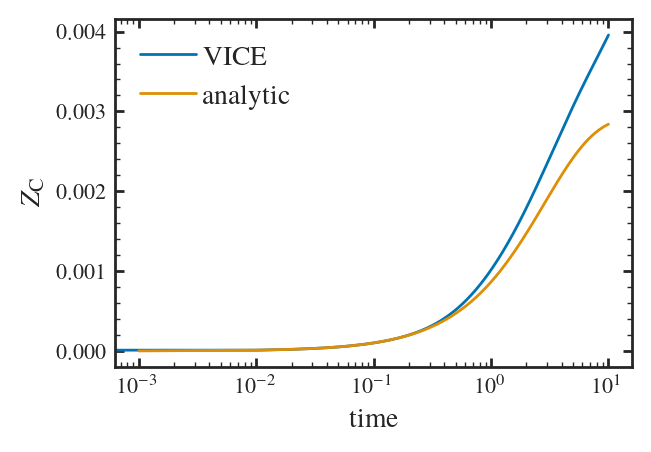

In [155]:
compare_z_t(sz, ana)

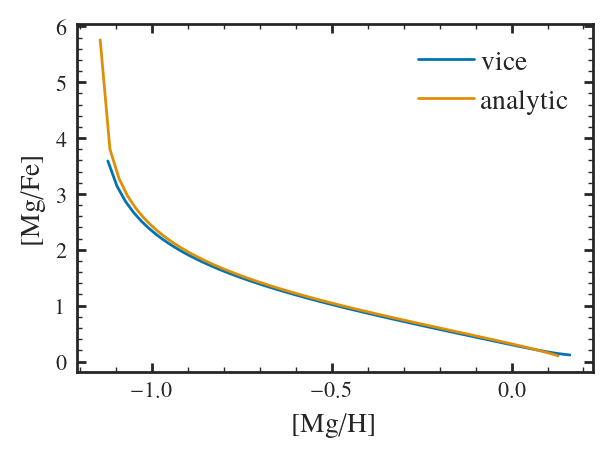

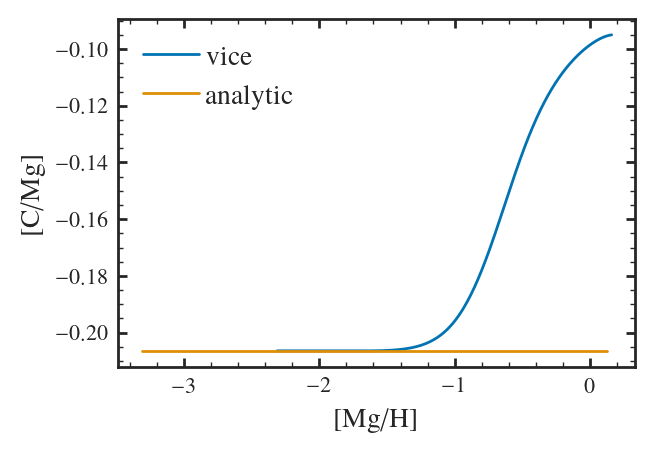

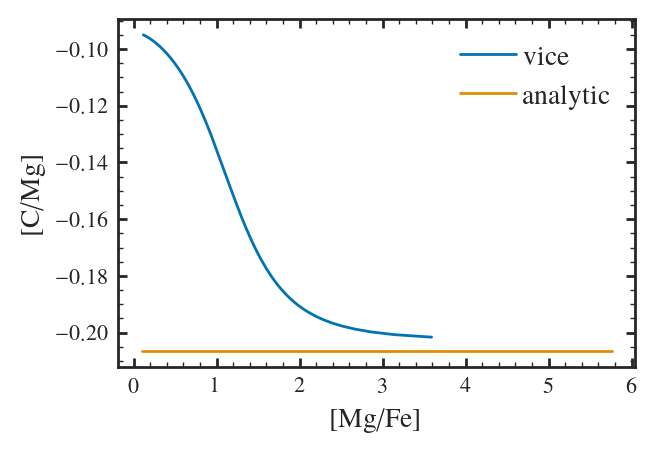

In [156]:
compare_abund(sz, ana)

In [157]:
Zeq_ia_exp(params) / Zeq_cc_exp(params.y_fe_ia, params)

np.float64(1.4720779056478814)

In [158]:
nu_fe_exp(100, params)

np.float64(1.4720779056478817)

In [159]:
sz["z(fe)"][-1] / Zeq_cc_exp(params.y_fe_ia, params)

1.3807578120953863

In [182]:
calc_nu_fe(sz)

np.float64(1.4610250382980574)

#

In [160]:
Rs = np.linspace(0, 15, 100)
tau_sfh = [surp.simulation.star_formation_history.get_sfh_timescale(R) for R in Rs]

nu = [nu_fe_exp(10, sz_params(sfh="exp", τ_sfh=t)) for t in tau_sfh]

(1.0, 2.0)

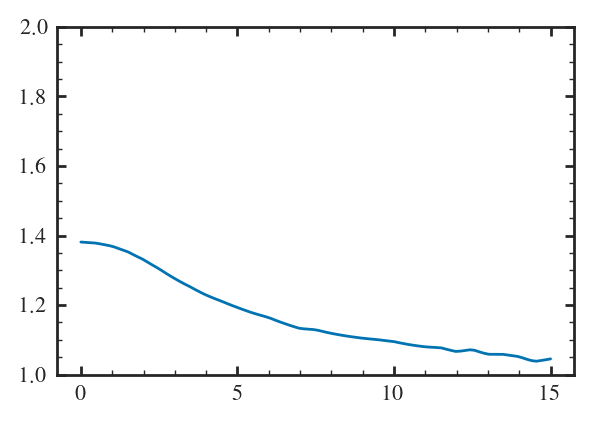

In [161]:
plt.plot(Rs, nu)
plt.ylim(1, 2)

In [177]:
def calc_nu_fe(h, ):
    "Returns the current rate of Fe injection at the given time for a singlezone-like history"
        
    Mdotstar = np.array(h["sfr"]) * 1e9
    tprime =np.array( h["time"])
    time = tprime[-1]

    dt = np.gradient(tprime)

    num = np.sum(Mdotstar * R_ia(time - tprime) * dt)

    return num / Mdotstar[-1]

In [181]:
def R_ia_unnorm(t):
    t_d = 0.15
    tau_ia = 1.5
    return np.where(t < 0.150, 0, np.exp(-(t-t_d) / tau_ia))

tprime = np.linspace(0.001, 15, 10000)

denom = np.sum(R_ia_unnorm(tprime) * np.gradient(tprime))


def R_ia(t):
    return R_ia_unnorm(t) / denom
